# Image Generation with Wasserstein Autoencoders

We'll build a deterministic Wasserstein autoencoder (WAE) to generate images inspired by the Fashion MNIST dataset.

## The Fashion MNIST dataset

The Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000$ examples. Each example is a $28\times28$ grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

We've organized these images in two folders named `train` and `test` in the GitHub repository https://github.com/DeepTrackAI/FashionMNIST_dataset:

In [1]:
import os

if not os.path.exists("FashionMNIST_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/FashionMNIST_dataset")

dir = os.path.join("FashionMNIST_dataset", "train")

In [2]:
print(f"{len(os.listdir(dir))} training images")

60000 training images


The labels of the classes are the following:

In [3]:
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", 
           "Shirt", "Sneaker", "Bag", "Ankle boot"]

We load the data using `Deeptrack2.0`. We will only use 6,000 images for training and 6,000 for test. We normalize the images in the range `[0, 1]`. We also define a pipeline to get images and labels of the test dataset.

In [4]:
import deeptrack as dt
import torch

files = dt.sources.ImageFolder(root=dir)
train_files, test_files, _ = dt.sources.random_split(files, [0.1, 0.1, 0.8])

train_pipeline = (
    dt.LoadImage(train_files.path)
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

2024-01-31 09:28:33.719367: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def get_label(label_name):
    """Get image label."""
    return label_name[0]

train_label = dt.Value(get_label, label_name=train_files.label_name)

We define the datasets and visualize some of the images in the test dataset with the corresponding label.

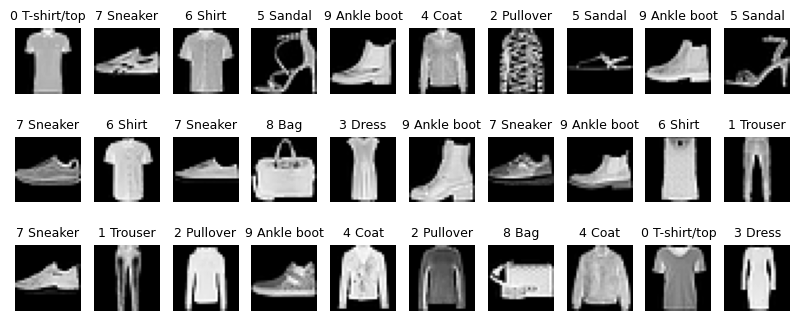

In [6]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 10, figsize=((10, 4)))
for ax, train_file in zip(axs.ravel(), np.random.choice(train_files, axs.size)):
    image, label = (train_pipeline & train_label)(train_file)
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(f"{int(label)} {classes[int(label)]}", fontsize=9)    
    ax.set_axis_off()

## Wasserstein autoencoder
We define the Wasserstein autoencoder architecture with a deterministic latent space of 8 dimension.

In [7]:
import deeplay as dl

latent_dimension = 8
wae = dl.WassersteinAutoEncoder(latent_dim=latent_dimension).create()

print(wae)

WassersteinAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (postprocess

We define the datasets, the dataloader and the trainer. We train the autoencder for `30` epochs.

In [8]:
from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(train_pipeline & train_pipeline, 
                                   inputs=train_files)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
wae_trainer = dl.Trainer(max_epochs=1000, accelerator="auto")                      ### Increase to 1000?
wae_trainer.fit(wae, train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name                | Type                   | Params
---------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 93.1 K
1 | fc_enc              | Linear                 | 50.2 K
2 | fc_dec              | Linear                 | 56.4

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


## Image Reconstruction

We check the WAE image reconstruction capability by comparing input images with autoencoder predictions

In [9]:
test_pipeline = (
    dt.LoadImage(test_files.path)
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)
test_label = dt.Value(get_label, label_name=test_files.label_name)
#test_dataset = dt.pytorch.Dataset(test_pipeline & test_label, 
#                                  inputs=test_files)

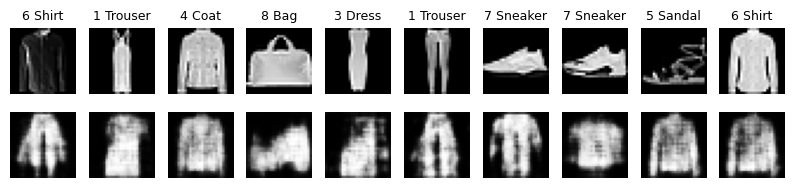

In [13]:
fig, axs = plt.subplots(2, 10, figsize=((10, 2)))
for i, test_file in enumerate(np.random.choice(test_files, 10)):
    image, label = (test_pipeline & test_label)(test_file)
    axs[0, i].imshow(image.squeeze(), cmap="gray")
    axs[0, i].set_title(f"{int(label)} {classes[int(label)]}", fontsize=9)    
    axs[0, i].set_axis_off()
    
    reconstructed_image, _ = wae(image.unsqueeze(0))
    axs[1, i].imshow(reconstructed_image.detach().squeeze(), cmap="gray")
    axs[1, i].set_axis_off()

## Image Generation
We'll generate images by sampling a continuous distribution of latent representations and reconstructing the images using the trained WAE’s decoder.

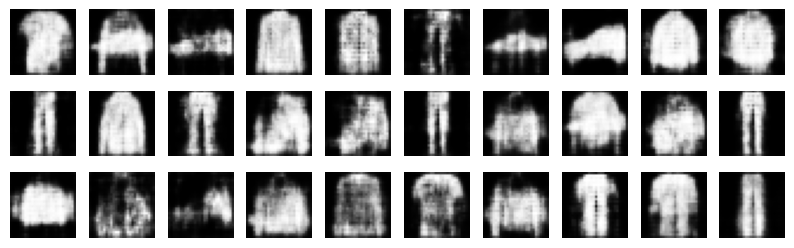

In [19]:
images = wae.decode(torch.randn(30, latent_dimension)).detach().squeeze()

fig, axs = plt.subplots(3, 10, figsize=((10, 3)))
for ax, image in zip(axs.ravel(), images):
    ax.imshow(image, cmap="gray")
    ax.set_axis_off()

## Image interpolation
We can use the latent space to interpolate between pairs of images by encoding them, linearly interpolate between their latent-space representations and decode the corresponding images. 

SourceItem({'path': 'FashionMNIST_dataset/train/8_49923.png', 'label': 37142, 'label_name': '8_49923.png'})

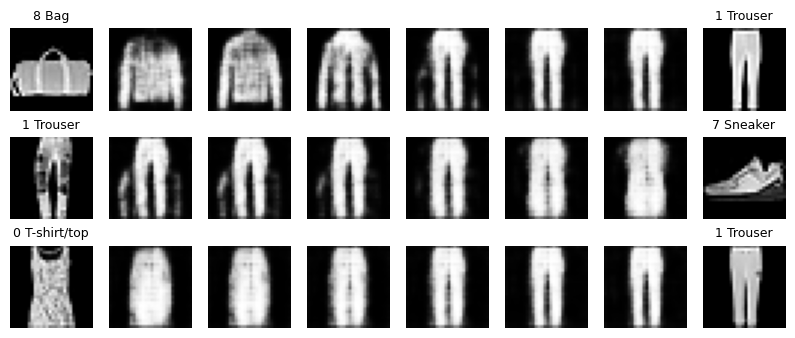

In [33]:
steps = 6

fig, axs = plt.subplots(3, steps + 2, figsize=((10, 4)))
for i, _ in enumerate(axs):
    test_file_0, test_file_1 = np.random.choice(test_files, 2)
    
    image_0, label_0 = (test_pipeline & test_label)(test_file_0)
    z_0 = wae.encode(image_0.unsqueeze(0))
    
    image_1, label_1 = (test_pipeline & test_label)(test_file_1)
    z_1 = wae.encode(image_1.unsqueeze(0))
    
    axs[i, 0].imshow(image_0.squeeze(), cmap="gray")
    axs[i, 0].set_title(f"{int(label_0)} {classes[int(label_0)]}", fontsize=9)    
    axs[i, 0].set_axis_off()
    
    for step in range(steps):
        z_step = z_0 + (z_1 - z_0) * step / (steps - 1)
        image_step = wae.decode(z_step).detach()
        axs[i, step + 1].imshow(image_step.squeeze(), cmap="gray")
        axs[i, step + 1].set_axis_off()
    
    axs[i, -1].imshow(image_1.squeeze(), cmap="gray")
    axs[i, -1].set_title(f"{int(label_1)} {classes[int(label_1)]}", fontsize=9)    
    axs[i, -1].set_axis_off()

plt.show()